In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import train_test_split,KFold,cross_val_score,GridSearchCV,RandomizedSearchCV
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
sns.set(rc={'figure.figsize':(8,8)})
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
SEED = 42

In [2]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:1459], all_data.loc[1460:]



In [3]:
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
y_train = train.SalePrice
id_val = train.Id
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
df_all = concat_df(train, test).drop(['SalePrice', 'Id'], axis=1)

train.name = 'Training Set'
test.name = 'Test Set'
df_all.name = 'All Set' 
dfs = [train, test]

In [4]:
df_all.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,EnclosedPorch,ExterCond,ExterQual,Exterior1st,Exterior2nd,Fence,FireplaceQu,Fireplaces,Foundation,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,GrLivArea,HalfBath,Heating,HeatingQC,HouseStyle,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MSZoning,MasVnrArea,MasVnrType,MiscFeature,MiscVal,MoSold,Neighborhood,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,RoofMatl,RoofStyle,SaleCondition,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,GLQ,Unf,1.0,0.0,Gd,150.0,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,NaN,NaN,0,PConc,2,Typ,548.0,2.0,TA,RFn,TA,Attchd,2003.0,1710,1,GasA,Ex,2Story,1,Gd,Lvl,Gtl,8450,Inside,65.0,Reg,0,60,RL,196.0,BrkFace,NaN,0,2,CollgCr,61,5,7,Y,0,NaN,CompShg,Gable,Normal,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,ALQ,Unf,0.0,1.0,Gd,284.0,Y,Feedr,Norm,SBrkr,0,TA,TA,MetalSd,MetalSd,NaN,TA,1,CBlock,2,Typ,460.0,2.0,TA,RFn,TA,Attchd,1976.0,1262,0,GasA,Ex,1Story,1,TA,Lvl,Gtl,9600,FR2,80.0,Reg,0,20,RL,0.0,None,NaN,0,5,Veenker,0,8,6,Y,0,NaN,CompShg,Gable,Normal,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,GLQ,Unf,1.0,0.0,Gd,434.0,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,NaN,TA,1,PConc,2,Typ,608.0,2.0,TA,RFn,TA,Attchd,2001.0,1786,1,GasA,Ex,2Story,1,Gd,Lvl,Gtl,11250,Inside,68.0,IR1,0,60,RL,162.0,BrkFace,NaN,0,9,CollgCr,42,5,7,Y,0,NaN,CompShg,Gable,Normal,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,ALQ,Unf,1.0,0.0,TA,540.0,Y,Norm,Norm,SBrkr,272,TA,TA,Wd Sdng,Wd Shng,NaN,Gd,1,BrkTil,1,Typ,642.0,3.0,TA,Unf,TA,Detchd,1998.0,1717,0,GasA,Gd,2Story,1,Gd,Lvl,Gtl,9550,Corner,60.0,IR1,0,70,RL,0.0,None,NaN,0,2,Crawfor,35,5,7,Y,0,NaN,CompShg,Gable,Abnorml,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,GLQ,Unf,1.0,0.0,Gd,490.0,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,NaN,TA,1,PConc,2,Typ,836.0,3.0,TA,RFn,TA,Attchd,2000.0,2198,1,GasA,Ex,2Story,1,Gd,Lvl,Gtl,14260,FR2,84.0,IR1,0,60,RL,350.0,BrkFace,NaN,0,12,NoRidge,84,5,8,Y,0,NaN,CompShg,Gable,Normal,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


<AxesSubplot:>

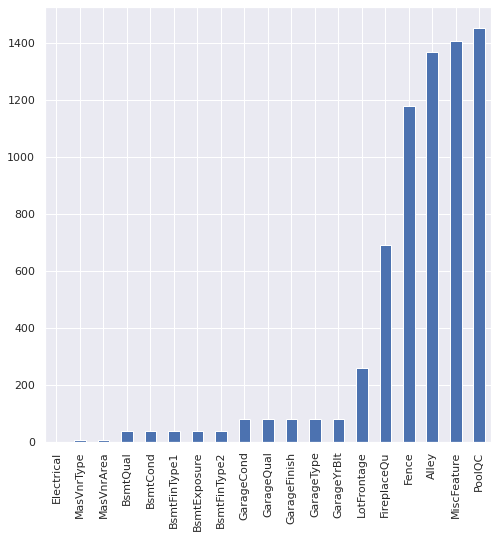

In [5]:
missing = train.isnull().sum()  ##train is pandas data frame 
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

**Below are the max missing values**
Pool quality, Misc features, Fense, Alley, Fireplace quality are having maximum N/A or missing values 


In [6]:
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']  ## Quantitative variables
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']  ## Categorial variables


In [7]:
for df in dfs:
    print(f'Only features contained missing value in {df.name}')
    temp = df.isnull().sum()
    print(temp.loc[temp!=0], '\n')

Only features contained missing value in Training Set
LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64 

Only features contained missing value in Test Set
MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76

In [8]:
df_train, df_test = divide_df(df_all)
df_train = pd.concat([df_train, y_train], axis=1)  # Concatenate for analysis

# Checking existing missing value or not
print(df_all.isnull().any().sum())

34


<AxesSubplot:title={'center':'Log Normal'}, xlabel='SalePrice'>

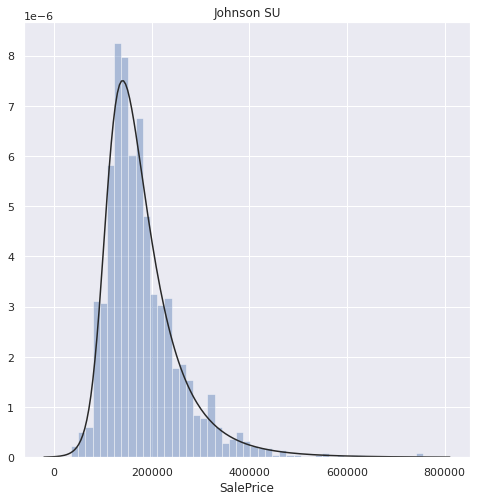

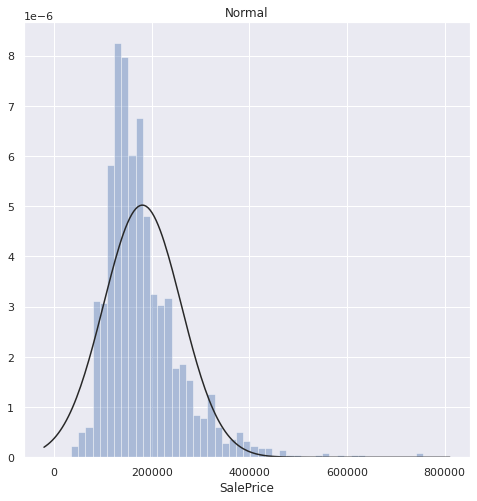

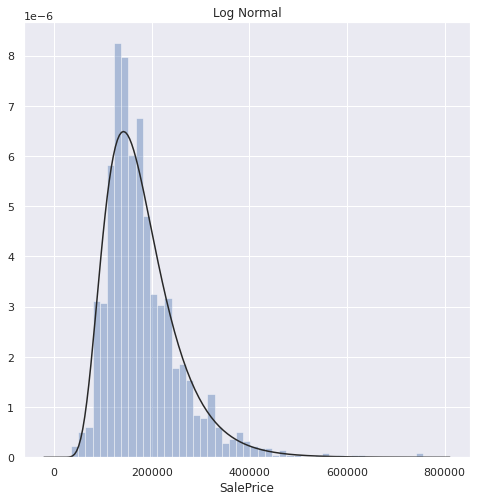

In [20]:
import scipy.stats as st
y = train['SalePrice']   ##Parameter to predict
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)

Johnson SU seems best fit for distribution

**Ditstribution of Numerical variables as follows**

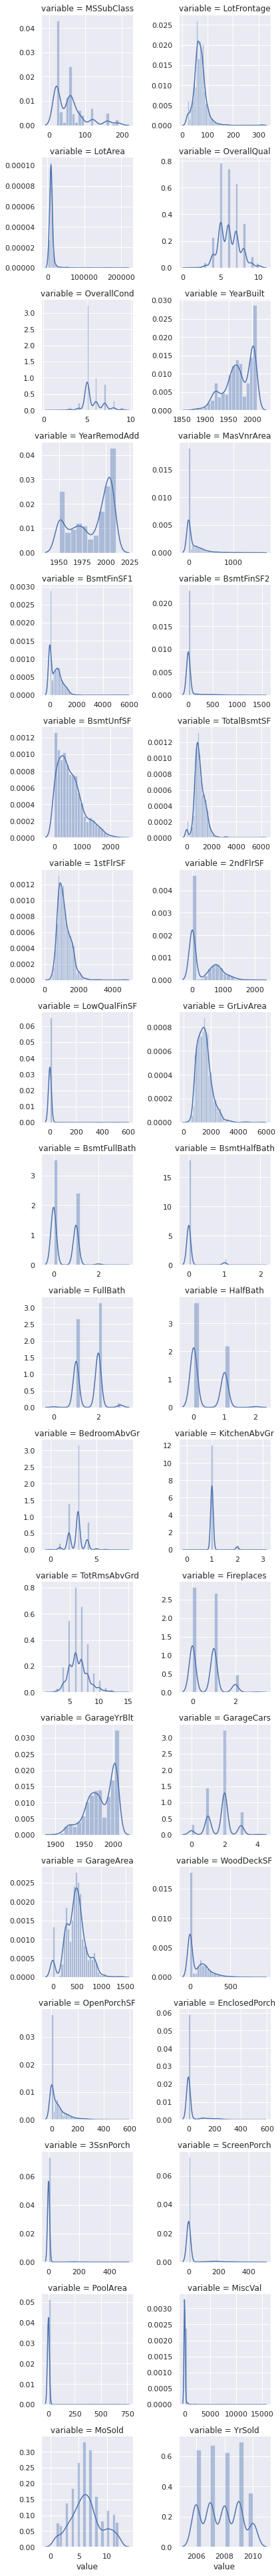

In [21]:
f = pd.melt(train, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

**Add missing as value for missing values in categorial**

In [22]:
for c in qualitative:
    train[c] = train[c].astype('category')
    if train[c].isnull().any():
        train[c] = train[c].cat.add_categories(['MISSING'])
        train[c] = train[c].fillna('MISSING')

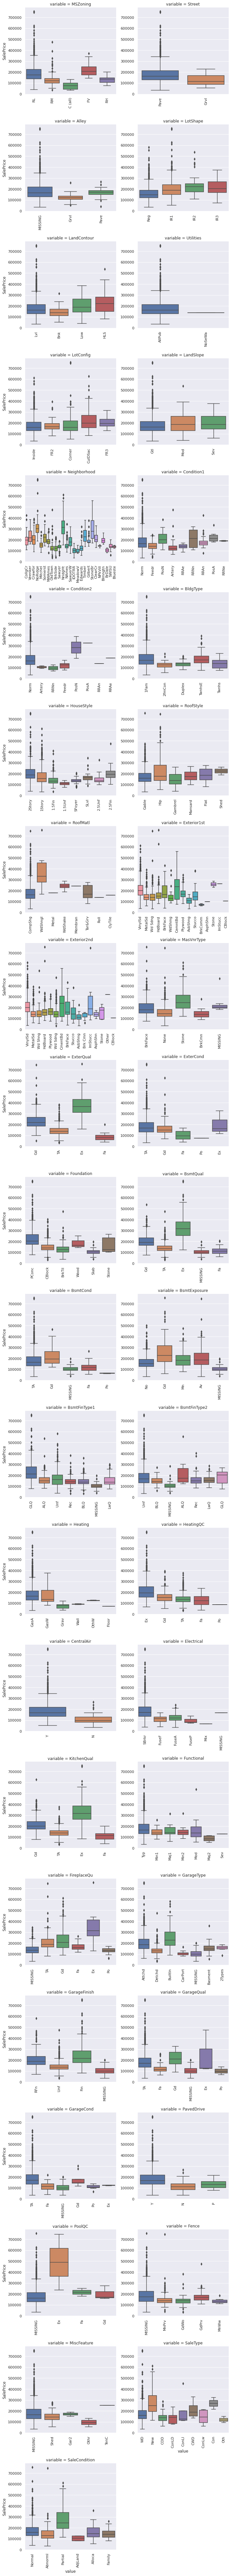

In [23]:
## Box plot of categorial variables with respect to price to understand which varibles to select
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
f = pd.melt(train, id_vars=['SalePrice'], value_vars=qualitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "SalePrice")

## Checking correlation of categorial variable with Anova

In [24]:
def anova(frame):
    anv = pd.DataFrame()
    anv['feature'] = qualitative
    pvals = []
    for c in qualitative:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['SalePrice'].values
            samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

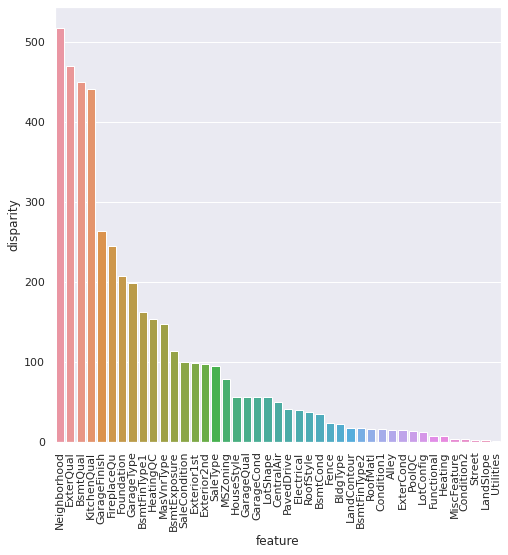

In [25]:
a = anova(train)
a['disparity'] = np.log(1./a['pval'].values)
sns.barplot(data=a, x='feature', y='disparity')
x=plt.xticks(rotation=90)


> Encoding all categorial variables 

In [26]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()  ## ALl unique values of categorial variables
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']  ## Group feature by mean sale price
    ordering = ordering.sort_values('spmean')  ## Sort feature by mean saleprice
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o

In [27]:
qual_encoded = []
for q in qualitative:  
    encode(train, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E']


Correlation

In [28]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]  #Correlation of all features with Price
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')  ## Horizontal bar plot of comparison of all correlation

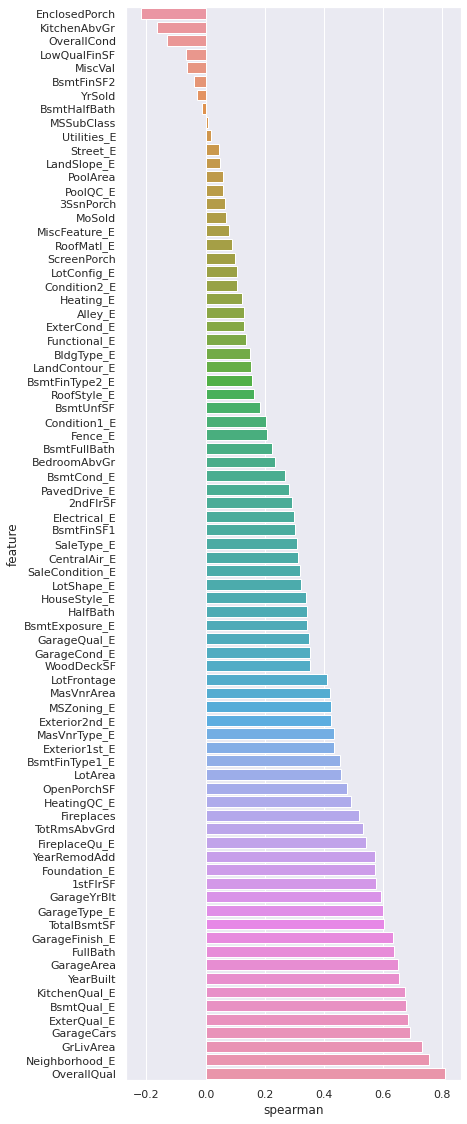

In [29]:
features = quantitative + qual_encoded
spearman(train, features)


# Heat map correlation

<AxesSubplot:>

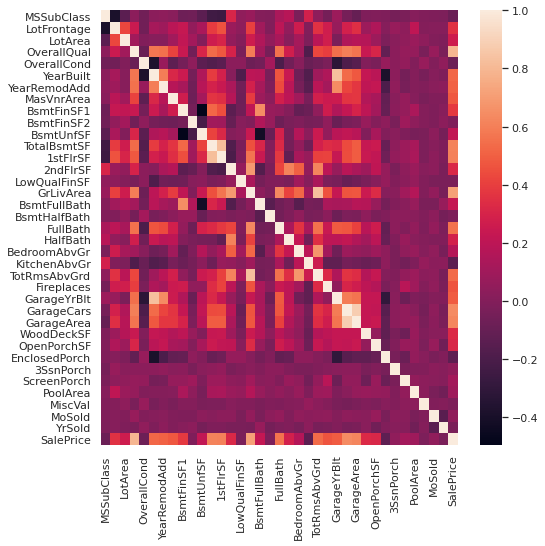

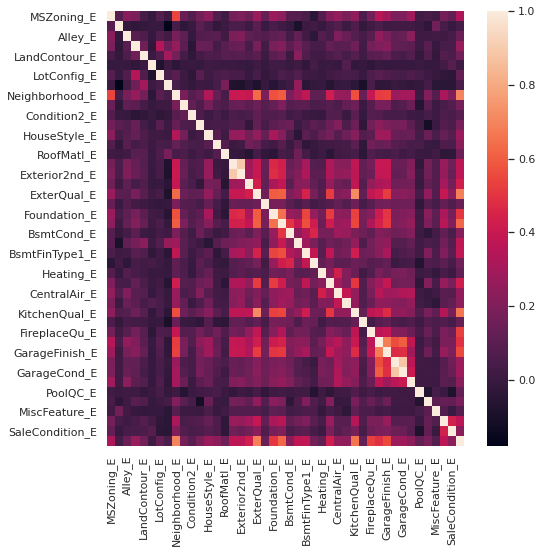

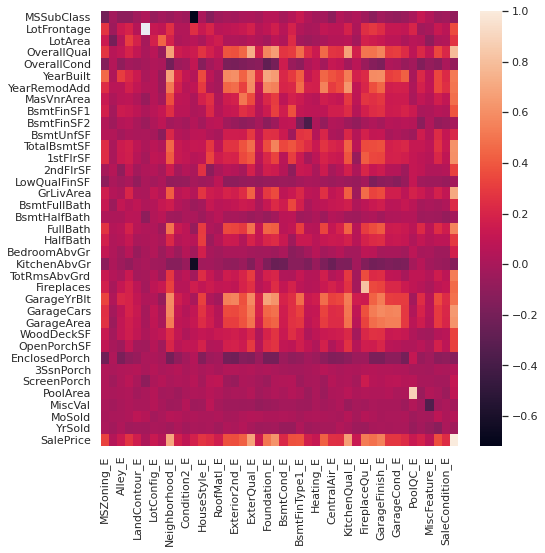

In [30]:
plt.figure(1)
corr = train[quantitative+['SalePrice']].corr()  # Correlation of numberical
sns.heatmap(corr)
plt.figure(2)
corr = train[qual_encoded+['SalePrice']].corr()  # Correlation of categorial 
sns.heatmap(corr)
plt.figure(3)
corr = pd.DataFrame(np.zeros([len(quantitative)+1, len(qual_encoded)+1]), index=quantitative+['SalePrice'], columns=qual_encoded+['SalePrice'])
for q1 in quantitative+['SalePrice']:
    for q2 in qual_encoded+['SalePrice']:
        corr.loc[q1, q2] = train[q1].corr(train[q2])
sns.heatmap(corr)

<a name='3'></a>
# 3. Feature engineering

#### Using "Bin" technique for all features having value representing "year" & encode them by label encoding technique

In [9]:
# Using binned technique for "YearBuilt", "YearRemodAdd" & "YrSold"
df_all['YearBuilt'] = pd.qcut(df_all['YearBuilt'], 10, duplicates='drop')
df_all['YearRemodAdd'] = pd.qcut(df_all['YearRemodAdd'], 10, duplicates='drop')
df_all['YrSold'] = pd.qcut(df_all['YrSold'], 10, duplicates='drop')

In [10]:
# Encode categorical features to numeric feature
for cate_col in ['YearBuilt', 'YearRemodAdd', 'YrSold']:
    df_all[cate_col] = preprocessing.LabelEncoder().fit_transform(df_all[cate_col].values)
    
df_train, df_test = divide_df(df_all)

<a name='3.1'></a>
## 3.1 Numeric features

#### Adding some important features

In [11]:
# Total square feet of porch in a house
df_all['TotalPorchSF'] = (df_all['OpenPorchSF'] + df_all['3SsnPorch'] +
                          df_all['EnclosedPorch'] + df_all['ScreenPorch'] + df_all['WoodDeckSF'])
df_all['HasGarage'] = df_all['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
# Total number of bathroom
df_all['TotalBath'] = (df_all['FullBath'] + (0.5 * df_all['HalfBath']) +
                       df_all['BsmtFullBath'] + (0.5 * df_all['BsmtHalfBath']))
# House having the fire place or not
df_all['HasFireplace'] = df_all['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
# Total number of bathroom in basement
df_all['TotalBsmtbath'] = df_all['BsmtFullBath'] + (0.5 * df_all['BsmtHalfBath'])
# Total square foot
df_all['TotalSF'] = df_all['BsmtFinSF1'] + df_all['BsmtFinSF2'] + df_all['1stFlrSF'] + df_all['2ndFlrSF']

In [12]:
# These columns are used for generating above new features --> Drop the old features
df_all.drop(['OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch', 'WoodDeckSF', 'FullBath', 'HalfBath',
            'BsmtFullBath', 'BsmtHalfBath'], axis=1, inplace=True)

#### Choosing numeric feature and normalize highly skewed features

In [13]:
num_features = ['OverallQual', 'GrLivArea', 'TotalSF', 'GarageCars', 'TotalBath', 'GarageArea', 'TotalBsmtSF',
 '1stFlrSF', 'TotRmsAbvGrd', 'MasVnrArea', 'HasFireplace', 'Fireplaces', 'TotalPorchSF', '2ndFlrSF',
 'LotArea', 'HasGarage', 'TotalBsmtbath', 'BsmtUnfSF', 'YearBuilt', 'YearRemodAdd', 'YrSold']

# Drop the unused numeric columns also
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_cols = df_all.select_dtypes(include=numeric_dtypes).columns
drop_num = np.setdiff1d(num_cols, num_features)

df_all.drop(drop_num, axis=1, inplace=True)

In [14]:
# Normalize skewness feature using Log function
skew_features = df_all[num_features].apply(lambda x: stats.skew(x)).sort_values(ascending=False)
skew_features = skew_features[abs(skew_features) > 0.5]
print(skew_features) 

# Apply Box cox for skewness > 0.75
for feat in skew_features.index:
    df_all[feat] = np.log1p(df_all[feat])

df_train, df_test = divide_df(df_all)

LotArea         12.822431
1stFlrSF         1.469604
TotalPorchSF     1.376649
GrLivArea        1.269358
2ndFlrSF         0.861675
TotRmsAbvGrd     0.758367
Fireplaces       0.733495
YrSold           0.566501
HasGarage       -3.941054
dtype: float64


In [15]:
df_train[num_features].head()

,OverallQual,GrLivArea,TotalSF,GarageCars,TotalBath,GarageArea,TotalBsmtSF,1stFlrSF,TotRmsAbvGrd,MasVnrArea,HasFireplace,Fireplaces,TotalPorchSF,2ndFlrSF,LotArea,HasGarage,TotalBsmtbath,BsmtUnfSF,YearBuilt,YearRemodAdd,YrSold
0,7,7.444833,2416.0,2.0,3.5,548.0,856.0,6.753438,2.197225,196.0,0,0.000000,4.127134,6.751101,9.042040,0.693147,1.0,150.0,7,6,0.693147
1,6,7.141245,2240.0,2.0,2.5,460.0,1262.0,7.141245,1.945910,0.0,1,0.693147,5.700444,0.000000,9.169623,0.693147,0.5,284.0,5,2,0.000000
2,7,7.488294,2272.0,2.0,3.5,608.0,920.0,6.825460,1.945910,162.0,1,0.693147,3.761200,6.765039,9.328212,0.693147,1.0,434.0,7,5,0.693147
3,7,7.448916,1933.0,3.0,2.0,642.0,756.0,6.869014,2.079442,0.0,1,0.693147,5.730100,6.629363,9.164401,0.693147,1.0,540.0,0,1,0.000000
4,8,7.695758,2853.0,3.0,3.5,836.0,1145.0,7.044033,2.302585,350.0,1,0.693147,5.624018,6.960348,9.565284,0.693147,1.0,490.0,7,5,0.693147


<a name='3.2'></a>
## 3.2 Categorical features

#### Some features having some values exist in training dataset but not in testing dataset --> We'll fix it

In [16]:
# "Electrical" features
df_train['Electrical'].loc[df_train['Electrical']=='Mix'] = 'SBrkr'
# "Exterior2nd" features
df_train['Exterior2nd'].loc[df_train['Exterior2nd']=='Other'] = 'VinylSd'
# "Heating" features
df_train['Heating'].loc[df_train['Heating']=='OthW'] = 'GasA'
df_train['Heating'].loc[df_train['Heating']=='Floor'] = 'GasA'
# "HouseStyle" features
df_train['HouseStyle'].loc[df_train['HouseStyle']=='2.5Fin'] = '1.5Fin'

#### Choosing the appropriate categorical features

In [17]:
cate_features = ['BldgType', 'BsmtExposure', 'BsmtFinType1', 'BsmtQual', 'CentralAir', 'Condition1', 'Electrical',
 'ExterCond', 'ExterQual', 'Exterior2nd', 'Functional', 'GarageCond', 'GarageType', 'Heating', 'HouseStyle',
 'KitchenQual', 'LandContour', 'LandSlope', 'LotShape', 'Neighborhood', 'PavedDrive', 'RoofStyle',
 'SaleCondition', 'SaleType', 'Street', 'YearBuilt', 'YearRemodAdd', 'YrSold']

# Drop the unused categorical columns by choosing the only set of columns above
cols = df_train.select_dtypes(include=['object', 'category']).columns
# Choose features only in "cols" but not in "cate_features"
drop_cate = np.setdiff1d(cols, cate_features)

df_train.drop(drop_cate, axis=1, inplace=True)
df_test.drop(drop_cate, axis=1, inplace=True)

#### Encode the categorical features by using One-hot encoding technique

In [18]:
print(df_train.shape, df_test.shape)

(1460, 46) (1459, 46)


In [19]:
# Transform categorical feature to dummies features
encoded_features = list()

for df in [df_train, df_test]:
    for feature in cate_features:
        # Change to array after encoding b.c want to add columns when change back to df
        encoded_feat = preprocessing.OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        # "n": Number of unique value in each feature
        n = df[feature].nunique()
        # "feature_uniqueVal" are the col's names in df after One-hot encoding
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)
        
df_train = pd.concat([df_train, *encoded_features[:len(cate_features)]], axis=1)
df_test = pd.concat([df_test, *encoded_features[len(cate_features):]], axis=1)

ValueError: Input contains NaN

In [ ]:
print(df_train.shape, df_test.shape)

#### Drop original category features, we only use one-hot features to train the model

In [ ]:
# Drop original category features
df_train.drop(cate_features, axis=1, inplace=True)
df_test.drop(cate_features, axis=1, inplace=True)

df_all = concat_df(df_train, df_test)

In [ ]:
print(df_train.shape, df_test.shape)

<a name='4'></a>
# 4. Modeling 

In [ ]:
from sklearn.model_selection import KFold # for repeated K-fold cross validation
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score # score evaluation

In [ ]:
# Repeated K-fold cross validation
kfolds = KFold(n_splits=10, shuffle=True, random_state=SEED)

# Return root mean square error applied cross validation (Used for training prediction)
def evaluate_model_cv(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

#### Initialize the xgboost model

In [ ]:
# Base model
xgboost = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                       max_depth=3, min_child_weight=0,
                       gamma=0, subsample=0.7,
                       colsample_bytree=0.7, verbosity = 0,
                       objective='reg:squarederror', nthread=-1,
                       scale_pos_weight=1, seed=SEED, reg_alpha=0.00006)

#### Training the model

In [ ]:
# Training model & find root mean square error (With cross validation technqiue)
xgboost = xgboost.fit(np.array(df_train), np.array(y_train))
print('Finish training')
cv_rmse_result = evaluate_model_cv(xgboost, np.array(df_train), np.array(y_train))
print(f'xgboost\'s rmse (apply cv) after training: {np.mean(cv_rmse_result)}\n')

#### Create the submission

In [ ]:
# Testing ID
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
test_id = test['Id']

# When normalize the target
submit = pd.concat((test_id, 
                    pd.Series(xgboost.predict(np.array(df_test)), name='SalePrice')), axis=1)
submit.to_csv('Submission.csv', index=False)

We got nearly 0.13185 prediction score on the leaderboard, rank in the top 10% competitor, I think this score is not a bad start

If you like this notebook, please give it an upvote. Thank you!